In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
# Percentages are mass percents. 
folsom_data = pd.read_excel('../data/total_biomass/Coli/Folsom2015_Microbiology.xlsx')

# Calculate the stoichiometries
amus = dict(C=12.011, H=1.00797, N=14.0067, O=15.9994, P=30.97376, S=32.06)
for e in 'CHNO':
    e_pct_col = '{0}_percent'.format(e)
    e_sem_col = '{0}_percent_SEM'.format(e)
    e_std_col = '{0}_percent_STD'.format(e)
    e_cv_col = '{0}_percent_CV'.format(e)
    
    e_stoich = '{0}_stoich'.format(e)
    e_stoich_STD = '{0}_stoich'.format(e)
    e_sem = folsom_data[e_sem_col]
    e_std = e_sem * folsom_data.n_replicates
    
    folsom_data[e_std_col] = e_sem * folsom_data.n_replicates
    folsom_data[e_cv_col] = e_std / folsom_data[e_pct_col]
    folsom_data[e_stoich] = folsom_data[e_pct_col] / amus[e]
    
    
stoich_cols = [c for c in folsom_data.columns
               if c.endswith('stoich')]
folsom_data[stoich_cols] = folsom_data[stoich_cols].divide(folsom_data.C_stoich, axis=0)
folsom_data['NOSC'] = 2*folsom_data.O_stoich + 3*folsom_data.N_stoich - folsom_data.H_stoich

folsom_data['experiment,growth_rate_hr,missing_percent,NOSC'.split(',') + stoich_cols]

,experiment,growth_rate_hr,missing_percent,NOSC,C_stoich,H_stoich,N_stoich,O_stoich
0,ammonium_limited,0.4,1.57,-0.063385,1.0,1.732574,0.212449,0.515921
1,ammonium_limited,0.3,3.13,-0.105217,1.0,1.723783,0.209012,0.495765
2,ammonium_limited,0.2,-0.44,0.076924,1.0,1.678807,0.196248,0.583494
3,ammonium_limited,0.1,6.82,-0.246887,1.0,1.740690,0.193439,0.456743
4,iron_limited,0.4,3.71,-0.115659,1.0,1.702649,0.241262,0.431602
5,iron_limited,0.3,8.08,-0.089677,1.0,1.673469,0.240485,0.431169
6,iron_limited,0.2,6.32,-0.157383,1.0,1.685633,0.241878,0.401308
7,iron_limited,0.1,5.63,-0.229871,1.0,1.699091,0.240964,0.373164
8,glucose_limited,0.4,3.27,-0.130690,1.0,1.727724,0.231342,0.451504
9,glucose_limited,0.3,3.58,-0.181489,1.0,1.716568,0.229079,0.423921


In [3]:
# In the Folsom data there is a missing percentage that's 1.5-8%. 
# Following Heldal et al. 1985, we will assume that this is 
# P+S with mass ratio P:S of ≈4-5:1. 

glucose_cond = 'glucose_limited'
glucose_exps = folsom_data.experiment == glucose_cond
samples_per_row = 10000
samples = []
for idx, row in folsom_data[glucose_exps].iterrows():
    for _ in range(samples_per_row):
        sample = dict(growth_rate_hr=row.growth_rate_hr, condition=glucose_cond)
        for e in 'CHNO':
            e_pct_col = '{0}_percent'.format(e)
            e_std_col = '{0}_percent_STD'.format(e)
            e_stoich_col = '{0}_stoich'.format(e)
            pct_sampled = np.random.normal(row[e_pct_col], row[e_std_col])
            sample[e_pct_col] = pct_sampled
            sample[e_stoich_col] = pct_sampled / amus[e]

        # sample the P
        PS_mass_ratio = np.random.uniform(4, 5)
        m = row.missing_percent
        P_pct = m * PS_mass_ratio / (1 + PS_mass_ratio)
        S_pct = m - P_pct
        sample['P_percent'] = P_pct
        sample['S_percent'] = S_pct
        sample['P_stoich'] = P_pct / amus['P']
        sample['S_stoich'] = S_pct / amus['S']
        samples.append(sample)
    
biomass_nosc_samples = pd.DataFrame(samples)
stoich_cols = [c for c in biomass_nosc_samples
               if c.endswith('stoich')]
biomass_nosc_samples[stoich_cols] = biomass_nosc_samples[stoich_cols].divide(
    biomass_nosc_samples.C_stoich, axis=0)

bns = biomass_nosc_samples
biomass_nosc_samples['NOSC'] = (2*bns.O_stoich + 3*bns.N_stoich - 5*bns.P_stoich 
                                - 4*bns.S_stoich - bns.H_stoich)
biomass_nosc_samples

,growth_rate_hr,condition,C_percent,C_stoich,H_percent,H_stoich,N_percent,N_stoich,O_percent,O_stoich,P_percent,S_percent,P_stoich,S_stoich,NOSC
0,0.4,glucose_limited,48.040254,1.0,6.720329,1.666928,12.982688,0.231741,28.920239,0.451931,2.641305,0.628695,0.021321,0.004903,-0.194058
1,0.4,glucose_limited,47.534982,1.0,6.830652,1.712302,12.726261,0.229578,26.806826,0.423358,2.633672,0.636328,0.021485,0.005015,-0.304337
2,0.4,glucose_limited,48.377591,1.0,6.989953,1.721716,12.600198,0.223345,26.439446,0.410283,2.724733,0.545267,0.021841,0.004223,-0.357208
3,0.4,glucose_limited,47.256350,1.0,6.884417,1.735955,12.717265,0.230769,27.415786,0.435528,2.714033,0.555967,0.022271,0.004408,-0.301579
4,0.4,glucose_limited,47.387459,1.0,6.961381,1.750506,12.745576,0.230643,29.099539,0.460997,2.693817,0.576183,0.022044,0.004555,-0.265025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.1,glucose_limited,47.796008,1.0,7.213727,1.798455,9.424442,0.169086,27.804414,0.436714,2.987711,0.692289,0.024240,0.005426,-0.560674
39996,0.1,glucose_limited,50.972865,1.0,7.421926,1.735038,10.417021,0.175246,26.024098,0.383276,3.039899,0.640101,0.023126,0.004705,-0.577198
39997,0.1,glucose_limited,49.369197,1.0,8.216613,1.983208,12.024890,0.208866,27.451849,0.417437,2.986969,0.693031,0.023462,0.005259,-0.660080
39998,0.1,glucose_limited,41.274084,1.0,8.600755,2.483080,13.201519,0.274277,27.313064,0.496785,2.989160,0.690840,0.028084,0.006271,-0.832180


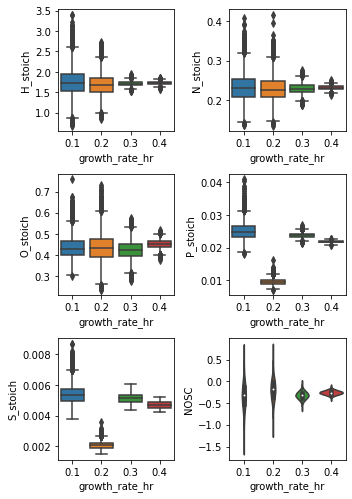

In [4]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(5, 7))
flat_axs = axs.flatten()

for i, e in enumerate('HNOPS'):
    col = '{0}_stoich'.format(e)
    plt.sca(flat_axs[i])
    sns.boxplot(data=biomass_nosc_samples, x='growth_rate_hr', y=col)
    
plt.sca(flat_axs[-1])
sns.violinplot(data=biomass_nosc_samples, x='growth_rate_hr', y='NOSC')

plt.tight_layout()
plt.show()

-0.258 +/- 0.049


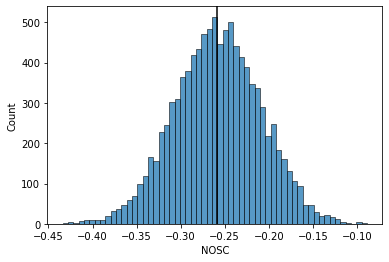

In [5]:
mask = biomass_nosc_samples.growth_rate_hr == 0.4
sns.histplot(data=biomass_nosc_samples[mask], x='NOSC')
mean = biomass_nosc_samples[mask].NOSC.mean()
std = biomass_nosc_samples[mask].NOSC.std()
plt.axvline(mean, ls='-', color='k')
print('{0:.3f} +/- {1:.3f}'.format(mean, std))
plt.show()